## Import relevant modules

In [1]:
#Import pandas and numpy
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Tweet cleaning
import re
from bs4 import BeautifulSoup
import contractions

#Sentiment analysis
#vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

#textblob
from textblob import TextBlob

#afinn
from afinn import Afinn

## Load data

In [2]:
#Read tweets into dataframe
sanders = pd.read_json('sanders_extended.json', lines=True)
warren = pd.read_json('warren_extended.json', lines=True)
biden = pd.read_json('biden_extended.json', lines=True)

In [3]:
#Label tweets by candidate
sanders['candidate'] = 'sanders'
warren['candidate'] = 'warren'
biden['candidate'] = 'biden'

In [4]:
#Drop column
warren = warren.drop(['withheld_in_countries'],axis=1)
biden = biden.drop(['withheld_in_countries'],axis=1)

In [5]:
#Add all tweets into one dataframe
merged_df = pd.concat([sanders,warren,biden],ignore_index=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85806 entries, 0 to 85805
Data columns (total 31 columns):
contributors                 0 non-null float64
coordinates                  61 non-null object
created_at                   85806 non-null datetime64[ns]
display_text_range           85806 non-null object
entities                     85806 non-null object
extended_entities            9319 non-null object
favorite_count               85806 non-null int64
favorited                    85806 non-null bool
full_text                    85806 non-null object
geo                          61 non-null object
id                           85806 non-null int64
id_str                       85806 non-null int64
in_reply_to_screen_name      32673 non-null object
in_reply_to_status_id        31118 non-null float64
in_reply_to_status_id_str    31118 non-null float64
in_reply_to_user_id          32673 non-null float64
in_reply_to_user_id_str      32673 non-null float64
is_quote_status            

In [6]:
df = merged_df.drop(['contributors','entities','extended_entities',
                                    'favorite_count','favorited','id_str','in_reply_to_screen_name',
                                    'in_reply_to_status_id','in_reply_to_status_id_str',
                                    'in_reply_to_user_id','in_reply_to_user_id_str','is_quote_status',
                                   'lang','possibly_sensitive','quoted_status','quoted_status_id',
                                   'quoted_status_id_str','retweet_count','retweeted',
                     'coordinates','geo','place','metadata','source','user','truncated',
                     'display_text_range','created_at'],
                            axis=1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85806 entries, 0 to 85805
Data columns (total 3 columns):
full_text    85806 non-null object
id           85806 non-null int64
candidate    85806 non-null object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


## Drop Duplicate Tweets Based on ID

In [8]:
df.shape

(85806, 3)

In [9]:
#Find duplicate tweets
print('There are', df[df.duplicated(subset='id')==True].sort_values(by='id').shape[0],'duplicates based on id')

There are 3300 duplicates based on id


In [10]:
#Find indices of duplicate tweets
duplicates = list(df[df.duplicated(subset='id')==True].sort_values(by='id').index)

#Drop duplicates and reset index
df.drop(duplicates,axis=0,inplace=True)
df.reset_index(inplace=True,drop=True)

In [11]:
#Find duplicate tweets
print('There are', df[df.duplicated(subset='full_text')==True].sort_values(by='id').shape[0],'duplicates based on text')

There are 873 duplicates based on text


In [12]:
#Find indices of duplicate tweets
duplicates = list(df[df.duplicated(subset='full_text')==True].sort_values(by='full_text').index)

#Drop duplicates and reset index
df.drop(duplicates,axis=0,inplace=True)
df.reset_index(inplace=True,drop=True)

In [13]:
#Number of rows after removing duplicates
print('There are', df.shape[0],'rows left after removing duplicates based on id and text.')

There are 81633 rows left after removing duplicates based on id and text.


## Clean Tweets

- Removing HTML tags
- Removing @mentions
- Removing URLs
- Expanding Contractions
- Removing special characters (punctuation, numbers, #s etc.)
- Removing white space and new line breaks

In [14]:
#Remove html tags
def strip_html_tags(tweet):
    soup = BeautifulSoup(tweet, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

#Remove @mentions
def remove_mentions(tweet):
    tweet = re.sub(r'@[\w]*','',tweet)
    return tweet

#remove urls(https://...)
def remove_url(tweet):
    tweet = re.sub(r'https?://[A-Za-z0-9./]*','',tweet)
    return tweet

#expand contractions
def expand_contractions(tweet):
    return contractions.fix(tweet)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

#remove new line breaks
def remove_new_lines(tweet):
    tweet = re.sub('[\r\n]',' ',tweet)
    return tweet

#remove white space
def remove_whitespace(tweet):
    tweet = re.sub(r'\s\s+',' ',tweet)
    tweet = tweet.lstrip(' ')
    return tweet

def clean_tweets(tweet):
    tweet = strip_html_tags(tweet) #Strip html tags
    tweet = strip_html_tags(tweet) #Once more to ensure all tags are removed
    tweet = remove_mentions(tweet) #Remove @mentions
    tweet = remove_url(tweet) #Remove urls
    tweet = expand_contractions(tweet) #Expand contractions
    special_char_pattern = re.compile(r'([{.(-)!}])')
    tweet = special_char_pattern.sub(" \\1 ", tweet)
    tweet = remove_special_characters(tweet,remove_digits=True) #Remove punctuation,numbers,hashtags. Keep emojis.
    tweet = remove_new_lines(tweet) #Remove new lines
    tweet = remove_whitespace(tweet) #Remove white space
    
    return tweet

clean_corpus = np.vectorize(clean_tweets)

In [15]:
#Save cleaned_tweets to new column
df['clean_tweets'] = clean_corpus(df['full_text'])

$Examples$

In [16]:
df.full_text[5]

'***NEW KOS POLL***\n\nAfter all the trash Markos has been tweeting about #BernieSanders lately, we need to make sure #Bernie wins this one.\n\nGo VOTE for #Bernie2020 and then retweet to spread the word!\n\n#NotMeUS\n#MedicareForAll\n\nhttps://t.co/Vw08gMFkRt'

In [17]:
df.clean_tweets[5]

'NEW KOS POLL After all the trash Markos has been tweeting about BernieSanders lately we need to make sure Bernie wins this one Go VOTE for Bernie and then retweet to spread the word NotMeUS MedicareForAll '

In [18]:
df.full_text[3]

'Schadenfreude: tfw you sit back and watch Bernie Sanders campaign totally unravel (while Warren’s soars) after he said he would have beaten Trump in 2016 had he been the nominee. \n\nI will 💯 vote for whichever Dem wins the primary, but I’m enjoying this a little bit...'

In [19]:
df.clean_tweets[3]

'Schadenfreude tfw you sit back and watch Bernie Sanders campaign totally unravel while Warrens soars after he said he would have beaten Trump in had he been the nominee I will vote for whichever Dem wins the primary but I am enjoying this a little bit '

## Sentiment Analysis Labels

### Vader Sentiment Analyzer

In [20]:
#Vader sentiment analysis
analyzer = SentimentIntensityAnalyzer()

#Function to return sentiment score from vader
def vader_sentiment_analyzer(text):
    score = analyzer.polarity_scores(text)
    compound = score['compound']
    #positive sentiment
    if compound >= 0.05:
        return 1
    #neutral sentiment
    elif (compound > -0.05) and (compound < 0.05):
        return 0
    #negative sentiment
    else:
        return -1

In [21]:
#Add vader sentiment to df
df['vader_sent'] = df['clean_tweets'].apply(lambda x: vader_sentiment_analyzer(x))

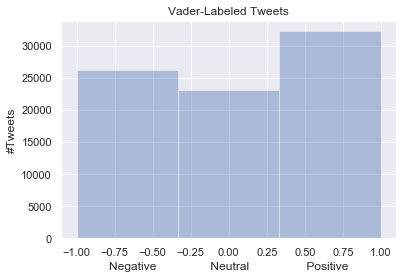

In [22]:
#Plot distribution of sentiments by vader
#Set Seaborn environment
sns.set()

#Plot distribution plot
ax = sns.distplot(
        df.vader_sent,
        kde=False,
        bins=3)
_ = ax.set(xlabel='Negative                Neutral                 Positive',ylabel='#Tweets',
          title="Vader-Labeled Tweets")

### TextBlob Sentiment Analyzer

In [23]:
def textblob_sentiment_analyzer(tweet):
    
    #Convert tweet to TextBlob object
    tb_tweet = TextBlob(tweet)
    #polarity score
    score = tb_tweet.polarity
    #positive sentiment
    if score >= 0.05:
        return 1
    #neutral sentiment
    elif (score > -0.05) and (score < 0.05):
        return 0
    #negative sentiment
    else:
        return -1

In [24]:
#Add TextBlog sentiment to df
df['tb_sent']=df['clean_tweets'].apply(lambda x: textblob_sentiment_analyzer(x))

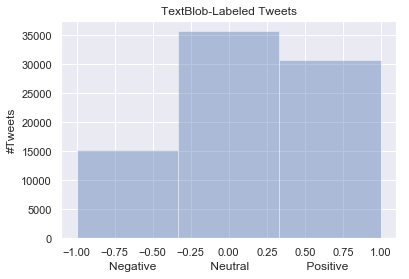

In [25]:
#Plot distribution of sentiments by TextBlob
ax = sns.distplot(
        df.tb_sent,
        kde=False,
        bins=3)
_ = ax.set(xlabel='Negative                Neutral                 Positive',ylabel='#Tweets',
          title="TextBlob-Labeled Tweets")

### AFINN Sentiment Analyzer

In [26]:
#Initialize Afinn and enable the emoticons lexicon
afinn = Afinn(emoticons=True)

#Create function return sentiment from AFINN lexicon
def afinn_score(tweet):
    #Afinn scores have a range of -5 to 5 so normalize to -1 to 1 to match textblob and vader
    score = afinn.score(tweet)/5
    #positive sentiment
    if score >= 0.05:
        return 1
    #neutral sentiment
    elif (score > -0.05) and (score < 0.05):
        return 0
    ##negative sentiment
    else:
        return -1

In [27]:
#Parse through clean tweets (no emojis) and add AFINN sentiment to df
df['afinn_sent']=df['clean_tweets'].apply(lambda x: afinn_score(x))

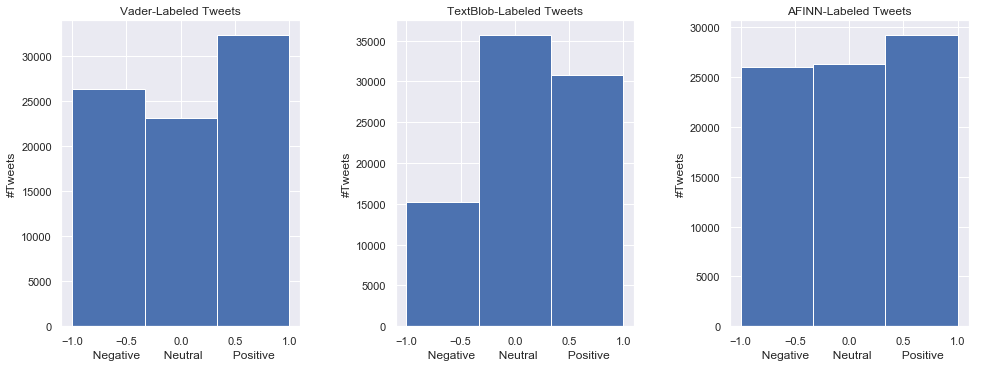

In [145]:
fig, axs = plt.subplots(1,3,figsize=(14,5))

#Plot distribution of sentiments by Vader
axs[0].hist(df.vader_sent,bins=3)
axs[0].set_xlabel('  Negative       Neutral         Positive')
axs[0].set_ylabel('#Tweets')
axs[0].set_title("Vader-Labeled Tweets")

#Plot distribution of sentiments by TextBlob
axs[1].hist(df.tb_sent,bins=3)
axs[1].set_xlabel('  Negative       Neutral         Positive')
axs[1].set_ylabel('#Tweets')
axs[1].set_title("TextBlob-Labeled Tweets")

#Plot distribution of sentiments by AFINN
axs[2].hist(df.afinn_sent,bins=3)
axs[2].set_xlabel('  Negative       Neutral         Positive')
axs[2].set_ylabel('#Tweets')
axs[2].set_title("AFINN-Labeled Tweets")

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=1.5, wspace=0.4)

### Comparison of Different Analyzers

In [29]:
print('Vader and TextBlob:', df[df['vader_sent'] == df['tb_sent']].shape[0])
print('Vader and AFINN:', df[df['vader_sent'] == df['afinn_sent']].shape[0])
print('AFINN and TextBlob:', df[df['afinn_sent'] == df['tb_sent']].shape[0])

Vader and TextBlob: 43565
Vader and AFINN: 65567
AFINN and TextBlob: 43972


## Import ~2000 manually labeled tweets

In [30]:
manual = pd.read_csv('manual_labels.csv')
manual['manual_sent']=manual.manual_labeled_sent.apply(lambda x: np.nan if x in ['7','-','77'] else x)

#Add manually labeled tweets to frame
merged = df.merge(manual[['id','manual_sent']],on='id')

#Extract sentiments only
merged = merged[['vader_sent','tb_sent','afinn_sent','manual_sent']]

#Drop rows with no manual sentiment
merged.dropna(inplace=True)

#Extract majority sentiment, if all 3 different, then go with vader
merged['majority'] = merged[['vader_sent','tb_sent','afinn_sent']].mode(axis=1)[0].astype(int)
merged.manual_sent = merged.manual_sent.astype(int)

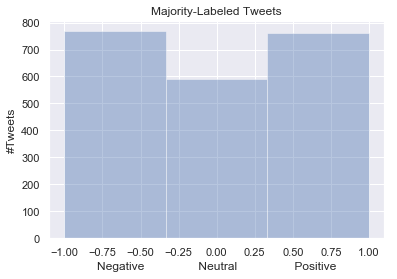

In [160]:
#Plot distribution of sentiments by TextBlob
ax = sns.distplot(
        merged.majority,
        kde=False,
        bins=3)
_ = ax.set(xlabel='Negative                Neutral                 Positive',ylabel='#Tweets',
          title="Majority-Labeled Tweets")

## Compare lexicon-based analyzer performance with manual labels

In [31]:
print("Matches between vader and manual: ",(merged.vader_sent == merged.manual_sent).sum(),'out of',merged.shape[0])
print("Matches between textblob and manual: ",(merged.tb_sent == merged.manual_sent).sum(),'out of',merged.shape[0])
print("Matches between afinn and manual: ",(merged.afinn_sent == merged.manual_sent).sum(),'out of',merged.shape[0])
print("Matches between majority and manual: ",(merged.majority == merged.manual_sent).sum(),'out of',merged.shape[0])

Matches between vader and manual:  978 out of 2122
Matches between textblob and manual:  962 out of 2122
Matches between afinn and manual:  985 out of 2122
Matches between majority and manual:  996 out of 2122


The majority label performs best.

## Label entire data set with majority label

In [32]:
df['sentiment'] = df[['vader_sent','tb_sent','afinn_sent']].mode(axis=1)[0].astype(int)

## Extract relevant columns to final dataframe

In [33]:
final = df[['id','candidate','clean_tweets','sentiment']]

In [34]:
final.head()

,id,candidate,clean_tweets,sentiment
0,1151202255334342656,sanders,First Joe Biden Must Earn A Delegate After Two...,-1
1,1151202130952380416,sanders,Elizabeth Warren thought she could go on The V...,1
2,1151202100845645826,sanders,he is never told Bernie Sanders to go back to ...,0
3,1151202000287125504,sanders,Schadenfreude tfw you sit back and watch Berni...,1
4,1151201985451966464,sanders,If you want to see socialism in Europe then su...,1


## Additional Text Pre-Processing for Feature Extraction

*Steps to reduce feature dimensinality:*
- Lemmatizing
- Removing stopwords

In [35]:
#Generate list of stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
for i in ['no','but','not','won']:
    stop_words.remove(i)

#remove common stopwords and 1 letter words
def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords and len(token)>1]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords and len(token)>1]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Lemmatizing
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
tag_map = {'j': wordnet.ADJ, 'v': wordnet.VERB, 'n': wordnet.NOUN, 'r': wordnet.ADV}
def lemmatization(tweet):
    tokens = nltk.word_tokenize(tweet)
    tagged_tokens = nltk.pos_tag(tokens)
    new_tagged_tokens = [(word, tag_map.get(tag[0].lower(), wordnet.NOUN))
                            for word, tag in tagged_tokens]
    lemmatized_text = ' '.join(wnl.lemmatize(word, tag) for word, tag in new_tagged_tokens)
    return lemmatized_text


def pre_process_tweets(tweet,remove_stops=True):
    tweet = tweet.lower() # lower case
    tweet = lemmatization(tweet) # lemmatizing text
    if remove_stops == True:
        tweet = remove_stopwords(tweet, is_lower_case=True, stopwords=stop_words) # remove stopwords
    # remove extra whitespace
    tweet = re.sub(' +', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [36]:
%%time

pre_process_corpus_nostops = np.vectorize(pre_process_tweets)
norm_tweets = pre_process_corpus_nostops(final.clean_tweets)

CPU times: user 2min 33s, sys: 1.65 s, total: 2min 34s
Wall time: 2min 35s


In [37]:
#Convert array normalized tweets into dataframe
norm_tweets_df = pd.DataFrame(norm_tweets)

#Add normalized tweets to final df
final = pd.concat([final,norm_tweets_df],axis=1)

#Rename normalized tweets to final tweets
final.rename(columns={0: "final_tweets"},inplace=True)

In [38]:
final.head()

,id,candidate,clean_tweets,sentiment,final_tweets
0,1151202255334342656,sanders,First Joe Biden Must Earn A Delegate After Two...,-1,first joe biden must earn delegate two campaig...
1,1151202130952380416,sanders,Elizabeth Warren thought she could go on The V...,1,elizabeth warren think could go view twice int...
2,1151202100845645826,sanders,he is never told Bernie Sanders to go back to ...,0,never tell bernie sander go back country
3,1151202000287125504,sanders,Schadenfreude tfw you sit back and watch Berni...,1,schadenfreude tfw sit back watch bernie sander...
4,1151201985451966464,sanders,If you want to see socialism in Europe then su...,1,want see socialism europe surely lead example ...


In [39]:
#Check for empty tweets in final_tweets
empty_tweets = list(final[final.final_tweets==""].index)

In [40]:
#Drop empty tweets
final.drop(empty_tweets,inplace=True)

# EDA: WordClouds

In [41]:
import wordcloud
from wordcloud import WordCloud,STOPWORDS

In [179]:
def word_cloud(wd_list):
    stopwords = list(STOPWORDS)
    words_to_add = ['Bernie Sanders','Elizabeth Warren','Joe Biden','Bernie','Sanders',
                   'Joe','Biden','Elizabeth','Warren','Kamala','Harris','Kamala Harris',
                   'ElizabethWarren','JoeBiden','BernieSanders','Sander','via','say','think',
                   'Trump','one','go','know','make','need','want','candidate','democrat']
    for i in words_to_add:
        stopwords.append(i)
    stopwords = set(stopwords)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=21,
        colormap='jet',
        max_words=50,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");

### All Sanders tweets

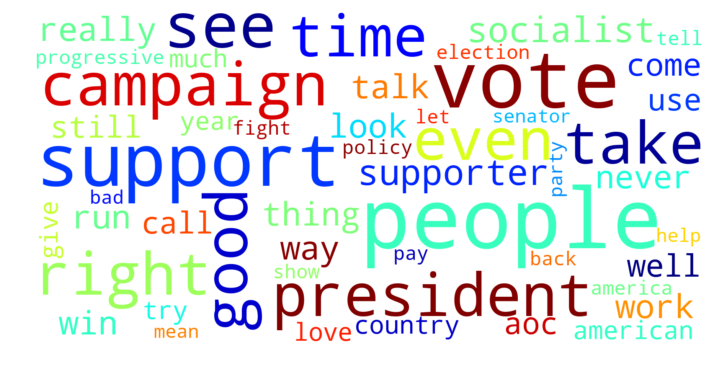

In [180]:
sanders_lst = [i for i in final.final_tweets[final.candidate=='sanders']]
word_cloud(sanders_lst)

### All Warren tweets

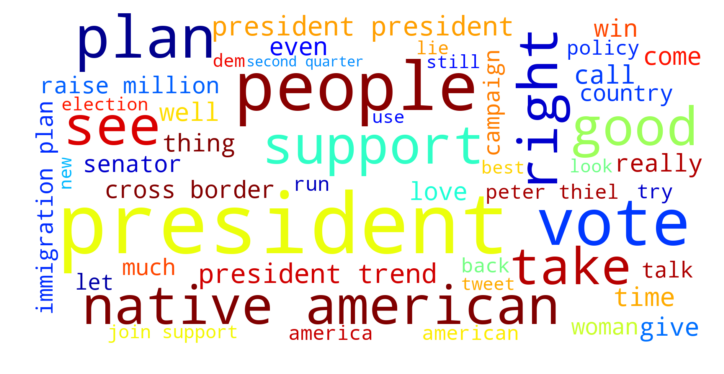

In [181]:
warren_lst = [i for i in final.final_tweets[final.candidate=='warren']]
word_cloud(warren_lst)

### All Biden tweets

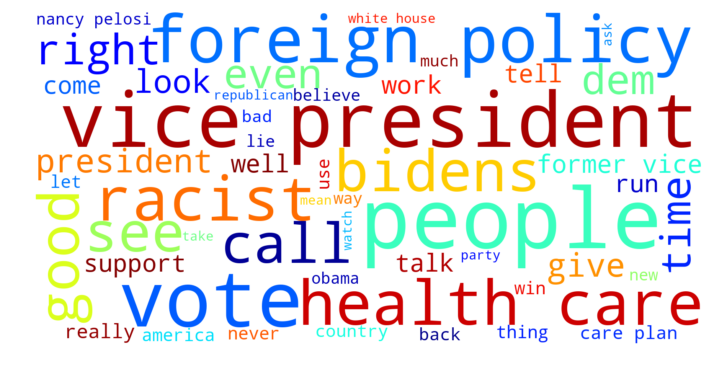

In [182]:
biden_lst = [i for i in final.final_tweets[final.candidate=='biden']]
word_cloud(biden_lst)

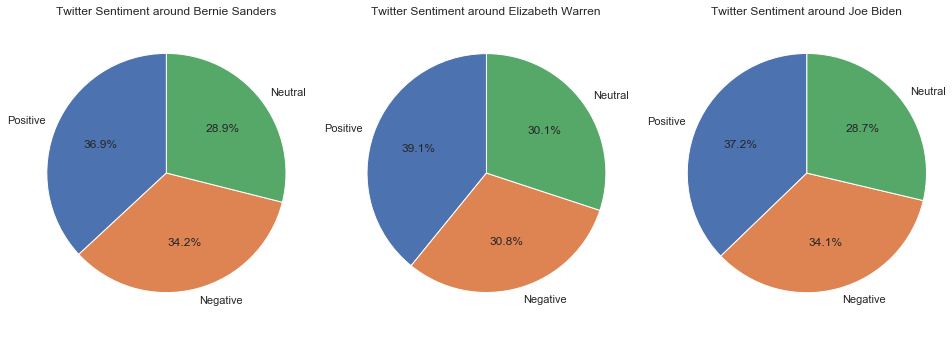

In [174]:
fig, axs = plt.subplots(1,3,figsize=(14,5))
data_sanders = final[final.candidate=='sanders'].sentiment.value_counts()
labels = ['Positive','Negative','Neutral']
axs[0].pie(data_sanders,startangle=90,labels=labels,autopct='%1.1f%%')
axs[0].axis('equal')
axs[0].set_title('Twitter Sentiment around Bernie Sanders')

data_warren = final[final.candidate=='warren'].sentiment.value_counts()
axs[1].pie(data_warren,startangle=90,labels=labels,autopct='%1.1f%%')
axs[1].axis('equal')
axs[1].set_title('Twitter Sentiment around Elizabeth Warren')

data_biden = final[final.candidate=='biden'].sentiment.value_counts()
axs[2].pie(data_biden,startangle=90,labels=labels,autopct='%1.1f%%')
axs[2].axis('equal')
axs[2].set_title('Twitter Sentiment around Joe Biden')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=1.5, wspace=0.2)

# Machine Learning

## Split final, pre-processed tweets into training and test set

In [53]:
sentiments = final.sentiment
tweets = final.final_tweets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tweets, sentiments, test_size=0.3, random_state=42)

## Feature Extraction and Engineering

### Bag-of-Words Model

In [54]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Initialize CountVectorizer for Bag-of-Words model.
#Set min # of tweets to 5 and max to 100%. Get unigrams and bigrams
cv = CountVectorizer(min_df=5, max_df=1.0, ngram_range=(1,2))

#Build Bag-of-Words features on training set
X_train_BOW = cv.fit_transform(X_train)

There are some potential problems which might arise with the Bag of Words model when it is used on large corpora. Since the feature vectors are based on absolute term frequencies, there might be some terms which occur frequently across all documents and these may tend to overshadow other terms in the feature set. The TF-IDF model tries to combat this issue by using a scaling or normalizing factor in its computation. TF-IDF stands for Term Frequency-Inverse Document Frequency, which uses a combination of two metrics in its computation, namely: 
- *term frequency* (tf) and 
- *inverse document frequency* (idf).

### TF-IDF Model

In [55]:
# build TFIDF features on train tweets
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
X_train_TFIDF = tv.fit_transform(X_train)

In [56]:
# transform test tweets into features
X_test_BOW = cv.transform(X_test)
X_test_TFIDF = tv.transform(X_test)

In [57]:
print('BOW model:> Train features shape:', X_train_BOW.shape, ' Test features shape:', X_test_BOW.shape)
print('TFIDF model:> Train features shape:', X_train_TFIDF.shape, ' Test features shape:', X_test_TFIDF.shape)

BOW model:> Train features shape: (57115, 25225)  Test features shape: (24478, 25225)
TFIDF model:> Train features shape: (57115, 25225)  Test features shape: (24478, 25225)


## Supervised Learning Models - Bag of Words

In [58]:
#Import models
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn.ensemble import RandomForestClassifier #random forest
from sklearn.naive_bayes import MultinomialNB #naive bayes

#Metric tools
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

### Logistic Regression - BOW

In [59]:
%%time

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, solver='newton-cg', random_state=42,multi_class='multinomial')

#Cross-validate on training set
cv_accuracy_lr = cross_val_score(lr, X_train_BOW, y_train,cv=5,scoring='accuracy')

# train model
lr.fit(X_train_BOW, y_train)

# predict on test data
y_pred_lr = lr.predict(X_test_BOW)

CPU times: user 53.3 s, sys: 960 ms, total: 54.3 s
Wall time: 54.5 s


In [60]:
print("Train Accuracy:",format(np.mean(cv_accuracy_lr),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_lr),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_lr),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_lr))

Train Accuracy: 0.85683
Test Accuracy: 0.86318
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6858          700          610
Actual 0          452         6434          343
Actual +          656          588         7837
              precision    recall  f1-score   support

          -1       0.86      0.84      0.85      8168
           0       0.83      0.89      0.86      7229
           1       0.89      0.86      0.88      9081

   micro avg       0.86      0.86      0.86     24478
   macro avg       0.86      0.86      0.86     24478
weighted avg       0.86      0.86      0.86     24478



### Random Forest - BOW

In [61]:
%%time

# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training se=-809\p
cv_accuracy_rf = cross_val_score(rf, X_train_BOW, y_train,cv=5,scoring='accuracy')

# train model
rf.fit(X_train_BOW, y_train)

# predict on test data
y_pred_rf = rf.predict(X_test_BOW)

CPU times: user 5min 30s, sys: 1.87 s, total: 5min 32s
Wall time: 5min 33s


In [62]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf))

Train Accuracy: 0.80510
Test Accuracy: 0.81567
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6077         1011         1080
Actual 0          414         6462          353
Actual +          834          820         7427
              precision    recall  f1-score   support

          -1       0.83      0.74      0.78      8168
           0       0.78      0.89      0.83      7229
           1       0.84      0.82      0.83      9081

   micro avg       0.82      0.82      0.82     24478
   macro avg       0.82      0.82      0.82     24478
weighted avg       0.82      0.82      0.81     24478



### Naive Bayes - BOW

In [63]:
%%time

#Initialize NB
nb = MultinomialNB()

#Cross-validate on training set
cv_accuracy_nb = cross_val_score(nb, X_train_BOW, y_train,cv=5,scoring='accuracy')

# train model
nb.fit(X_train_BOW, y_train)

# predict on test data
y_pred_nb = nb.predict(X_test_BOW)

CPU times: user 219 ms, sys: 52.1 ms, total: 272 ms
Wall time: 304 ms


In [64]:
print("Train Accuracy:",format(np.mean(cv_accuracy_nb),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_nb),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_nb),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_nb))

Train Accuracy: 0.75012
Test Accuracy: 0.74994
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6187          574         1407
Actual 0         1104         4738         1387
Actual +         1087          562         7432
              precision    recall  f1-score   support

          -1       0.74      0.76      0.75      8168
           0       0.81      0.66      0.72      7229
           1       0.73      0.82      0.77      9081

   micro avg       0.75      0.75      0.75     24478
   macro avg       0.76      0.74      0.75     24478
weighted avg       0.75      0.75      0.75     24478



## Supervised Learning Models - TF-IDF

### Logistic Regression - TF-IDF

In [65]:
%%time

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, solver='newton-cg', random_state=42,multi_class='multinomial')

#Cross-validate on training set
cv_accuracy_lr_tfidf = cross_val_score(lr, X_train_TFIDF, y_train,cv=5,scoring='accuracy')

# train model
lr.fit(X_train_TFIDF, y_train)

# predict on test data
y_pred_lr_tfidf = lr.predict(X_test_TFIDF)

CPU times: user 18 s, sys: 332 ms, total: 18.4 s
Wall time: 18.8 s


In [66]:
print("Train Accuracy:",format(np.mean(cv_accuracy_lr_tfidf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_lr_tfidf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_lr_tfidf),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_lr_tfidf))

Train Accuracy: 0.84517
Test Accuracy: 0.85460
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6812          623          733
Actual 0          549         6256          424
Actual +          700          530         7851
              precision    recall  f1-score   support

          -1       0.85      0.83      0.84      8168
           0       0.84      0.87      0.85      7229
           1       0.87      0.86      0.87      9081

   micro avg       0.85      0.85      0.85     24478
   macro avg       0.85      0.85      0.85     24478
weighted avg       0.85      0.85      0.85     24478



### Random Forest - TF-IDF

In [67]:
%%time

# instantiate model to run 50 estimators on all processors
rf = RandomForestClassifier(n_estimators=50, random_state=42)

#Cross-validate on training set
cv_accuracy_rf_tfidf = cross_val_score(rf, X_train_TFIDF, y_train,cv=5,scoring='accuracy')

# train model
rf.fit(X_train_TFIDF, y_train)

# predict on test data
y_pred_rf_tfidf = rf.predict(X_test_TFIDF)

CPU times: user 4min 24s, sys: 1.48 s, total: 4min 25s
Wall time: 4min 25s


In [68]:
print("Train Accuracy:",format(np.mean(cv_accuracy_rf_tfidf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_rf_tfidf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_rf_tfidf),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_rf_tfidf))

Train Accuracy: 0.78275
Test Accuracy: 0.79696
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6004          991         1173
Actual 0          625         6143          461
Actual +          919          801         7361
              precision    recall  f1-score   support

          -1       0.80      0.74      0.76      8168
           0       0.77      0.85      0.81      7229
           1       0.82      0.81      0.81      9081

   micro avg       0.80      0.80      0.80     24478
   macro avg       0.80      0.80      0.80     24478
weighted avg       0.80      0.80      0.80     24478



### Naive Bayes - TF-IDF

In [69]:
%%time

from sklearn.naive_bayes import MultinomialNB

#Initialize NB
nb = MultinomialNB()

#Cross-validate on training set
cv_accuracy_nb_tfidf = cross_val_score(nb, X_train_TFIDF, y_train,cv=5,scoring='accuracy')

# train model
nb.fit(X_train_TFIDF, y_train)

# predict on test data
y_pred_nb_tfidf = nb.predict(X_test_TFIDF)

CPU times: user 210 ms, sys: 34.5 ms, total: 245 ms
Wall time: 244 ms


In [70]:
print("Train Accuracy:",format(np.mean(cv_accuracy_nb_tfidf),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_nb_tfidf),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_nb_tfidf),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_nb_tfidf))

Train Accuracy: 0.74483
Test Accuracy: 0.74594
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6192          448         1528
Actual 0         1084         4395         1750
Actual +          959          450         7672
              precision    recall  f1-score   support

          -1       0.75      0.76      0.75      8168
           0       0.83      0.61      0.70      7229
           1       0.70      0.84      0.77      9081

   micro avg       0.75      0.75      0.75     24478
   macro avg       0.76      0.74      0.74     24478
weighted avg       0.76      0.75      0.74     24478



### Performance Comparison: Logistic Regression Model with the Stopwords

While removing stopwords is often common practice, it can sometimes negatively affect the performance of the classifier. We can compare the performance of the logistic regression classifier on the tweets with and without the stopwords.

In [71]:
%%time

#Extract df
final_temp = df[['id','candidate','clean_tweets','sentiment']]

#Normalize tweets WITHOUT removing stopwords
pre_process_corpus_withstops = np.vectorize(pre_process_tweets)
norm_tweets_withstops = pre_process_corpus_withstops(final_temp.clean_tweets,remove_stops=False)

#Convert array normalized tweets into dataframe
norm_tweets_withstops_df = pd.DataFrame(norm_tweets_withstops)

#Add normalized tweets to final df
final_withstops = pd.concat([final_temp,norm_tweets_withstops_df],axis=1)

#Rename normalized tweets to final tweets
final_withstops.rename(columns={0: "final_tweets"},inplace=True)

#Check for empty tweets in final_tweets
empty_tweets = list(final_withstops[final_withstops.final_tweets==""].index)

#Drop empty tweets
final_withstops.drop(empty_tweets,inplace=True)

#split tweets into training test set
sentiments_withstops = final_withstops.sentiment
tweets_withstops = final_withstops.final_tweets

X_train_ws, X_test_ws, y_train_ws, y_test_ws = train_test_split(tweets_withstops, 
                                                                sentiments_withstops,
                                                                test_size=0.3, random_state=42)

#Fit and Transfom Bag of Words model on train and test set
X_train_BOW_ws = cv.fit_transform(X_train_ws)
X_test_BOW_ws = cv.transform(X_test_ws)

print('BOW model:> Train features shape:', X_train_BOW_ws.shape, ' Test features shape:', X_test_BOW_ws.shape)

BOW model:> Train features shape: (57140, 38546)  Test features shape: (24489, 38546)
CPU times: user 2min 10s, sys: 1.47 s, total: 2min 11s
Wall time: 2min 12s


In [72]:
%%time

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, solver='newton-cg', random_state=42,multi_class='multinomial')

#Cross-validate on training set
cv_accuracy_lr = cross_val_score(lr, X_train_BOW_ws, y_train_ws,cv=5,scoring='accuracy')

# train model
lr.fit(X_train_BOW_ws, y_train_ws)

# predict on test data
y_pred_lr = lr.predict(X_test_BOW_ws)

CPU times: user 1min 42s, sys: 2.1 s, total: 1min 44s
Wall time: 1min 44s


In [73]:
print("Train Accuracy:",format(np.mean(cv_accuracy_lr),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test_ws, y_pred_lr),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test_ws, y_pred_lr),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test_ws, y_pred_lr))

Train Accuracy: 0.85056
Test Accuracy: 0.85332
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6902          740          762
Actual 0          440         6318          404
Actual +          643          603         7677
              precision    recall  f1-score   support

          -1       0.86      0.82      0.84      8404
           0       0.82      0.88      0.85      7162
           1       0.87      0.86      0.86      8923

   micro avg       0.85      0.85      0.85     24489
   macro avg       0.85      0.85      0.85     24489
weighted avg       0.85      0.85      0.85     24489



### Performance Comparison:  Logistic Regression Model with Bag-of-Words with 1 to 3-grams

In [74]:
%%time

#Set min # of tweets to 5 and max to 100%. Get unigrams and bigrams
cv_3 = CountVectorizer(min_df=5, max_df=1.0, ngram_range=(1,3))

#Fit and Transfom Bag of Words model on train and test set
X_train_BOW_3 = cv_3.fit_transform(X_train)
X_test_BOW_3 = cv_3.transform(X_test)

print('BOW model:> Train features shape:', X_train_BOW_3.shape, ' Test features shape:', X_test_BOW_3.shape)

BOW model:> Train features shape: (57115, 35548)  Test features shape: (24478, 35548)
CPU times: user 7 s, sys: 287 ms, total: 7.28 s
Wall time: 7.42 s


In [78]:
%%time

# instantiate model
lr = LogisticRegression(penalty='l2', max_iter=500, solver='newton-cg', random_state=42,multi_class='multinomial')

#Cross-validate on training set
cv_accuracy_lr = cross_val_score(lr, X_train_BOW_3, y_train,cv=5,scoring='accuracy')

# train model
lr.fit(X_train_BOW_3, y_train)

# predict on test data
y_pred_lr = lr.predict(X_test_BOW_3)

CPU times: user 58 s, sys: 757 ms, total: 58.7 s
Wall time: 58.8 s


In [79]:
print("Train Accuracy:",format(np.mean(cv_accuracy_lr),'.5f'))
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred_lr),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_lr),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_lr))

Train Accuracy: 0.85314
Test Accuracy: 0.86114
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6838          700          630
Actual 0          449         6434          346
Actual +          654          620         7807
              precision    recall  f1-score   support

          -1       0.86      0.84      0.85      8168
           0       0.83      0.89      0.86      7229
           1       0.89      0.86      0.87      9081

   micro avg       0.86      0.86      0.86     24478
   macro avg       0.86      0.86      0.86     24478
weighted avg       0.86      0.86      0.86     24478



### Final Model: Hyperparameter tuning of Logistic Regression

In [86]:
%%time

from dask_searchcv import GridSearchCV
from dask.diagnostics import ProgressBar

# instantiate model
lr = LogisticRegression(max_iter=500, solver='newton-cg', random_state=42, multi_class='multinomial')

#Paramgrid
param = {'C': np.linspace(1,1e5,5)}

#Cross-validate on training set
log_reg_grid = GridSearchCV(lr,param,cv=5)

# train model
with ProgressBar():
    log_reg_grid.fit(X_train_BOW, y_train)
# predict on test data
y_pred_lr = log_reg_grid.predict(X_test_BOW)

[########################################] | 100% Completed | 11min 42.4s
CPU times: user 36min 37s, sys: 32.8 s, total: 37min 10s
Wall time: 11min 42s


In [87]:
print("Train Accuracy:",format(log_reg_grid.best_score_,'.5f'))
print('Training Parameters:', log_reg_grid.best_params_)
print("Test Accuracy:",format(log_reg_grid.score(X_test_BOW, y_test),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_lr),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred_lr))

Train Accuracy: 0.85683
Training Parameters: {'C': 1.0}
Test Accuracy: 0.86318
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         6858          700          610
Actual 0          452         6434          343
Actual +          656          588         7837
              precision    recall  f1-score   support

          -1       0.86      0.84      0.85      8168
           0       0.83      0.89      0.86      7229
           1       0.89      0.86      0.88      9081

   micro avg       0.86      0.86      0.86     24478
   macro avg       0.86      0.86      0.86     24478
weighted avg       0.86      0.86      0.86     24478



# Supervised Deep Learning

To prepare text data for our deep learning model, we transform each tweet into a sequence. Every word in the tweet is mapped to an integer index and thus the tweet turns into a sequence of numbers.

## Convert words to sequences (indices) 

In [88]:
from keras.preprocessing.text import Tokenizer

#Initialize tokenizer and fit on training set
t = Tokenizer()
t.fit_on_texts(X_train)

#Convert words to sequences
train_sequences = t.texts_to_sequences(X_train)
test_sequences = t.texts_to_sequences(X_test)

#size of vocabulary. 
#We add 1, because we will need to specify the integer for the largest encoded word as an array index.
vocab_size = len(t.word_counts)+1

print("Vocabulary size={}".format(vocab_size))
print("Number of Documents={}".format(t.document_count))

Using TensorFlow backend.


Vocabulary size=30094
Number of Documents=57115


## Pad sequences so all documents are the same length

Not all tweets are of same length. To handle this difference in length of tweets, we define a maximum length to be the length of the longest tweet. For tweets which are smaller than this length, they are padded with 0s. This is a requirement when using Keras.

In [89]:
from keras.preprocessing.sequence import pad_sequences

#Get maximum tweet length in words
max_length = np.max([len(i) for i in train_sequences])

# pad dataset to max tweet length
X_train_padded = pad_sequences(train_sequences, maxlen=max_length)
X_test_padded = pad_sequences(test_sequences, maxlen=max_length)

print('Max length of train tweet vectors:', max_length)
print('Train tweet vectors shape:', X_train_padded.shape, ' Test tweet vectors shape:', X_test_padded.shape)

Max length of train tweet vectors: 42
Train tweet vectors shape: (57115, 42)  Test tweet vectors shape: (24478, 42)


## Encode target labels

Form multi-class predictions, the loss function 'categorical_crossentropy' can be used in the deep model. It requires target variables to be hot-encoded so we will encode our predictor labels.

In [90]:
from sklearn.preprocessing import LabelEncoder

#Initialize encoder
le = LabelEncoder()
num_classes=3 # positive -> 2, neutral -> 1, negative -> 0

#Transform labels into positive integers
train_y = le.fit_transform(y_train)
test_y = le.transform(y_test)

#One hot encoding of integers
from keras.utils import np_utils
train_y = np_utils.to_categorical(train_y)
test_y = np_utils.to_categorical(test_y)

## Build LSTM Model Architecture

In [184]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from keras.layers import LSTM

EMBEDDING_DIM = 128 # dimension for dense embeddings for each token
LSTM_DIM = 64 # total LSTM units

def model_architecture():
    
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(LSTM_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(3, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="adam",metrics=["accuracy"])
    
    return model

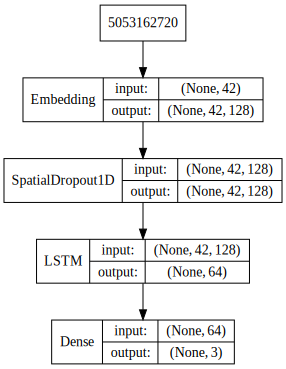

In [198]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras
keras.utils.vis_utils.pydot = pydot

model = model_architecture()

SVG(model_to_dot(model, show_shapes=True, show_layer_names=False, 
                 rankdir='TB').create(prog='dot', format='svg'))

In [92]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 42, 128)           3852032   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 42, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 3,901,635
Trainable params: 3,901,635
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
batch_size = 100
model.fit(X_train_padded, train_y, epochs=5, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 51403 samples, validate on 5712 samples
Epoch 1/5
51403/51403 [==============================] - 78s 2ms/step - loss: 0.5886 - acc: 0.7573 - val_loss: 0.3860 - val_acc: 0.8643
Epoch 2/5
51403/51403 [==============================] - 74s 1ms/step - loss: 0.3023 - acc: 0.8966 - val_loss: 0.3558 - val_acc: 0.8724
Epoch 3/5
51403/51403 [==============================] - 74s 1ms/step - loss: 0.2304 - acc: 0.9233 - val_loss: 0.3694 - val_acc: 0.8776
Epoch 4/5
51403/51403 [==============================] - 75s 1ms/step - loss: 0.1876 - acc: 0.9372 - val_loss: 0.3797 - val_acc: 0.8738
Epoch 5/5
51403/51403 [==============================] - 75s 1ms/step - loss: 0.1526 - acc: 0.9475 - val_loss: 0.4168 - val_acc: 0.8727


## Predict on test set

In [94]:
pred_test = model.predict_classes(X_test_padded)
y_pred = le.inverse_transform(pred_test.flatten())

In [95]:
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_pred),'.5f'))
cnf_matrix = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred),
             columns = ['Predicted -', 'Predicted 0','Predicted +'],
             index=['Actual -', 'Actual 0','Actual +'])
print('Confusion Matrix: ')
print(cnf_matrix)
print(classification_report(y_test, y_pred))

Test Accuracy: 0.87552
Confusion Matrix: 
          Predicted -  Predicted 0  Predicted +
Actual -         7033          364          771
Actual 0          555         6186          488
Actual +          601          268         8212
              precision    recall  f1-score   support

          -1       0.86      0.86      0.86      8168
           0       0.91      0.86      0.88      7229
           1       0.87      0.90      0.89      9081

   micro avg       0.88      0.88      0.88     24478
   macro avg       0.88      0.87      0.88     24478
weighted avg       0.88      0.88      0.88     24478



# Topic Modeling

### Organize tweets by candidate and remove the names of candidates and additional stopwords from tweets

In [220]:
#Extract separate tweets per candidate
sanders_tweets = final[final.candidate=='sanders'][['final_tweets','sentiment']]

warren_tweets = final[final.candidate=='warren'][['final_tweets','sentiment']]

biden_tweets = final[final.candidate=='biden'][['final_tweets','sentiment']]


stopwords_candidate = ['bernie','sander','donald','trump','kamala','harris','elizabeth','warren','joe','biden',
                      'no','not','but','say','via','go','get','would']

#Remove candidate names from tweets
sanders = sanders_tweets.final_tweets.apply(lambda x: remove_stopwords(x, is_lower_case=True, stopwords=stopwords_candidate))
warren = warren_tweets.final_tweets.apply(lambda x: remove_stopwords(x, is_lower_case=True, stopwords=stopwords_candidate))
biden = biden_tweets.final_tweets.apply(lambda x: remove_stopwords(x, is_lower_case=True, stopwords=stopwords_candidate))


Using one of the most basic models, we can try to identify key topics based on term frequencies using a Bag-of-Words model. In other words, we can look at the most common words used in the tweets about the candidates to identify topics.

### Function to get most common words

In [206]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [221]:
print('10 most common words in Sanders tweets:')
get_top_n_words(sanders)

10 most common words in Sanders tweets:


[('like', 2967),
 ('berniesanders', 2954),
 ('people', 2790),
 ('vote', 2325),
 ('candidate', 2181),
 ('one', 1937),
 ('democrat', 1937),
 ('want', 1892),
 ('support', 1685),
 ('campaign', 1658)]

In [222]:
print('10 most common words in Warren tweets:')
get_top_n_words(warren)

10 most common words in Warren tweets:


[('president', 4667),
 ('plan', 2004),
 ('like', 1750),
 ('candidate', 1203),
 ('american', 1202),
 ('make', 1196),
 ('think', 1135),
 ('people', 1099),
 ('want', 1076),
 ('vote', 1069)]

In [223]:
print('10 most common words in Biden tweets:')
get_top_n_words(biden)

10 most common words in Biden tweets:


[('president', 2458),
 ('bidens', 2096),
 ('like', 2077),
 ('obama', 1768),
 ('democrat', 1527),
 ('make', 1385),
 ('racist', 1284),
 ('people', 1276),
 ('think', 1239),
 ('year', 1236)]

Unfortunately, there don't seem to be an emergence of any clear topics simply by looking at the most common words. The next step is to try a more complicated model. We will try 2 models: Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA). NMF is an unsupervised learning algorithm that simultaneously performs dimensionality reduction and clustering. We can use it in conjunction with Term-frequency / Inverse document-frequency (Tf-Idf) to model topics across the tweets. 

**What is LDA???**

## Model Functions

In [224]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

#Define function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print([feature_names[index] for index in topic.argsort()[:-no_top_words - 1:-1]])
        print('\n')
        
#Assign topic to tweet    
def assign_topic(array):
    lst = []
    for tweet in array:
        max_val = tweet[0]
        max_index = 0
        for index in range(len(tweet)):
            if tweet[index] > max_val:
                max_val = tweet[index]
                max_index = index
        lst.append(max_index)
    return lst

def topic_model(model,corpus,no_top_words=10):
    if model == 'nmf':
        #Initialize TV
        tv = TfidfVectorizer(min_df=5, max_df=1.0, ngram_range=(1,3),sublinear_tf=True)
        #Initialize model
        model = NMF(n_components=5, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
        #Transform tweets and get feature names
        tweets_transformed = tv.fit_transform(corpus)
        feature_names = tv.get_feature_names()
        
    elif model == 'lda':
        #Initialize CV
        cv = CountVectorizer(min_df=5, max_df=1.0, ngram_range=(1, 3))
        #Initialize model
        model = LatentDirichletAllocation(n_components=5, 
                                max_iter=5, 
                                learning_method='online', 
                                learning_offset=50.,
                                random_state=0)
        #Transform tweets and get feature names
        tweets_transformed = cv.fit_transform(corpus)
        feature_names = cv.get_feature_names()
        
    
    #Fit model
    model.fit(tweets_transformed)
    #Display topics
    display_topics(model, feature_names, no_top_words)
    
    #Get topic matrix
    topic_matrix = model.transform(tweets_transformed)
    
    return assign_topic(topic_matrix)

### Sanders topics - NMF Model

In [225]:
sanders_tweets['topic'] = topic_model('nmf',sanders)

Topic 0:
['like', 'berniesanders', 'vote', 'president', 'people', 'democrat', 'one', 'candidate', 'support', 'want']


Topic 1:
['contribute', 'contribute notmeus', 'notmeus', 'join', 'please', 'email', 'please donate', 'dedicate', 'donation', 'donate']


Topic 2:
['climate', 'emergency', 'declare', 'aoc', 'declare climate', 'climate change', 'change', 'climate emergency', 'congress declare', 'congress']


Topic 3:
['perot', 'ross', 'sword', 'ross perot', 'give', 'perot give', 'ross perot give', 'give sword', 'perot give sword', 'gift']


Topic 4:
['worry overpromising', 'overpromising', 'worry', 'nowthis', 'worry overpromising nowthis', 'overpromising nowthis', 'berniesanders worry', 'berniesanders', 'notmeus', 'feelthebern']




It looks like there is some relationship between the words in the topics. We can go in and manually assign labels to the topics.
    
**Topic 0**: Candidacy for president

**Topic 1**: Campaign for Donations

**Topic 2**: Climate Change

**Topic 3**: Ross Perot's gift (sword)

**Topic 4**: NowThis's Interview of Bernie Sanders

### Warren topics

In [227]:
warren_tweets['topic'] = topic_model('nmf',warren)

Topic 0:
['president', 'never', 'never president', 'president president', 'sound', 'like', 'presidentelizabethwarren', 'good', 'make', 'love']


Topic 1:
['join support', 'join', 'support', 'donate', 'support president', 'candidate', 'liz', 'let', 'donate president', 'call']


Topic 2:
['cross border', 'cross', 'illegally', 'border', 'border illegally', 'cross border illegally', 'illegally law', 'border illegally law', 'law', 'criminal offense']


Topic 3:
['gaza', 'occupation', 'end', 'israel', 'end israels occupation', 'end israels', 'israels occupation', 'israels', 'occupation gaza', 'israels occupation gaza']


Topic 4:
['trend', 'president trend', 'president', 'see', 'see president trend', 'see president', 'twitter', 'love', 'trend twitter', 'president trend twitter']




**Topic 0**: Candidacy for president (both positive and negative emotions)

**Topic 1**: Campaign for Donations

**Topic 2**: Immigration and Border Policy

**Topic 3**: Israel

**Topic 4**: "President Warren" trending on Twitter

### Biden topics

In [229]:
biden_tweets['topic'] = topic_model('nmf',biden)

Topic 0:
['refuse apologize', 'deportation number', 'refuse apologize high', 'high deportation number', 'high deportation', 'apologize high deportation', 'apologize high', 'number obama', 'deportation number obama', 'obama year']


Topic 1:
['cornel', 'cornel west', 'west', 'take cnn', 'cornel west take', 'west take', 'west take cnn', 'cnn', 'take', 'shot support']


Topic 2:
['care', 'health', 'plan', 'health care', 'health care plan', 'care plan', 'president', 'like', 'bidens', 'act']


Topic 3:
['family separation', 'separation', 'need family separation', 'need family', 'gaffe', 'family', 'immigration need', 'immigration need family', 'gaffe immigration need', 'gaffe immigration']


Topic 4:
['respect', 'border', 'respect border', 'respect border contain', 'border contain', 'border contain wall', 'contain wall', 'contain', 'wall', 'declare respect border']




**Topic 0**: Refusing to Apologize for Deportations during Obama's Administration

**Topic 1**: Cornel West

**Topic 2**: Health Care

**Topic 3**: Family Separation/Immigration

**Topic 4**: Border Policy

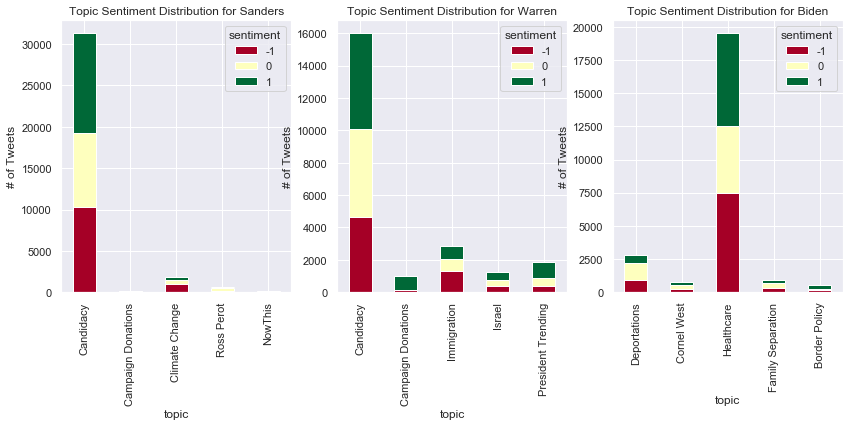

In [256]:
fig, axs = plt.subplots(1,3,figsize=(14,5))

#sanders tweets
grouped_sanders = sanders_tweets[['topic','sentiment']].groupby(['topic','sentiment'])['sentiment'].count()
_ = grouped_sanders.unstack().plot(ax=axs[0],kind='bar',stacked=True,colormap='RdYlGn')
labels = ['Candidacy','Campaign Donations','Climate Change','Ross Perot','NowThis']
axs[0].set_xticklabels(labels, rotation='vertical')
axs[0].set_ylabel('# of Tweets')
axs[0].set_title('Topic Sentiment Distribution for Sanders')

#warren tweets
grouped_warren = warren_tweets[['topic','sentiment']].groupby(['topic','sentiment'])['sentiment'].count()
_ = grouped_warren.unstack().plot(ax=axs[1],kind='bar',stacked=True,colormap='RdYlGn')
labels = ['Candidacy','Campaign Donations','Immigration','Israel','President Trending']
axs[1].set_xticklabels(labels, rotation='vertical')
axs[1].set_ylabel('# of Tweets')
axs[1].set_title('Topic Sentiment Distribution for Warren')

#biden tweets
grouped_biden = biden_tweets[['topic','sentiment']].groupby(['topic','sentiment'])['sentiment'].count().unstack()
grouped_biden.plot(ax=axs[2],kind='bar',stacked=True,colormap='RdYlGn')
labels = ['Deportations','Cornel West','Healthcare','Family Separation','Border Policy']
axs[2].set_xticklabels(labels, rotation='vertical')
axs[2].set_ylabel('# of Tweets')
_ = axs[2].set_title('Topic Sentiment Distribution for Biden')

## LDA Model

### Initialize LDA Model

In [231]:
%%time 

_ = topic_model('lda',sanders)

Topic 0:
['candidate', 'presidential', 'poll', 'democratic', 'campaign', 'billionaire', 'new', 'million', 'news', 'sen']


Topic 1:
['like', 'people', 'berniesanders', 'vote', 'one', 'want', 'know', 'think', 'make', 'support']


Topic 2:
['ocasiocortez', 'alexandria', 'last', 'alexandria ocasiocortez', 'pelosi', 'young', 'nancy', 'canada', 'nancy pelosi', 'insulin']


Topic 3:
['hillary', 'climate', 'clinton', 'hospital', 'war', 'emergency', 'medium', 'call', 'corporate', 'hillary clinton']


Topic 4:
['money', 'plan', 'pay', 'tax', 'student', 'debt', 'berniesanders', 'free', 'government', 'medicare']


CPU times: user 56.6 s, sys: 770 ms, total: 57.4 s
Wall time: 58.4 s


### Warren Topics

In [232]:
%%time 

_ = topic_model('lda',warren)

Topic 0:
['like', 'vote', 'president', 'think', 'people', 'see', 'need', 'elizabethwarren', 'plan', 'win']


Topic 1:
['president', 'end', 'israel', 'occupation', 'take', 'run', 'one', 'never', 'election', 'call']


Topic 2:
['plan', 'american', 'president', 'border', 'immigration', 'native', 'law', 'native american', 'cross', 'illegally']


Topic 3:
['campaign', 'million', 'raise', 'quarter', 'raise million', 'support', 'big', 'second', 'second quarter', 'donor']


Topic 4:
['democratic', 'candidate', 'sen', 'primary', 'presidential', 'race', 'rise', 'new', 'plan', 'democratic primary']


CPU times: user 38.6 s, sys: 514 ms, total: 39.1 s
Wall time: 39.8 s


### Biden Topics

In [233]:
%%time 

_ = topic_model('lda',biden)

Topic 0:
['like', 'president', 'racist', 'vote', 'people', 'democrat', 'call', 'one', 'good', 'make']


Topic 1:
['need', 'bidens', 'try', 'think', 'use', 'tell', 'border', 'win', 'want', 'campaign']


Topic 2:
['president', 'vice', 'vice president', 'former', 'bidens', 'democratic', 'obama', 'tax', 'former vice', 'former vice president']


Topic 3:
['policy', 'foreign', 'foreign policy', 'race', 'drop', 'leave', 'house', 'become', 'white house', 'speech']


Topic 4:
['care', 'health', 'plan', 'health care', 'act', 'bidens', 'health care plan', 'care plan', 'insurance', 'policy']


CPU times: user 42.6 s, sys: 486 ms, total: 43.1 s
Wall time: 43.7 s


# References:

- Lexicon vs. Machine Learning: https://www.emerald.com/insight/content/doi/10.1108/JCM-03-2017-2141/full/html
- Bag of Words and TF-IDF: https://towardsdatascience.com/understanding-feature-engineering-part-3-traditional-methods-for-text-data-f6f7d70acd41
- ML and Deep Learning for Twitter Sentiment Analysis: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-11-cnn-word2vec-41f5e28eda74
- Word2Vec by DJ: https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
- Word2Vec at a higher level: https://medium.com/explore-artificial-intelligence/word2vec-a-baby-step-in-deep-learning-but-a-giant-leap-towards-natural-language-processing-40fe4e8602ba
- Word Embedding for Sentiment Classification: https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456

**Topic Modeling**: 
- Topic Modeling (LDA and NMF): https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
- Evaluation of Topic Modeling Techniques for Twitter: https://docs.google.com/viewer?url=https%3A%2F%2Fwww.cs.toronto.edu%2F~jstolee%2Fprojects%2Ftopic.pdf
- Intuitive Guide to LDA: https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158